In [12]:
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

import numpy as np
import scipy.io

import nibabel
from scipy.interpolate import interpn

import sys
sys.path.append("/home/caskeylab/Vandiver/repos/fus_igt/py/")
import imagemanip
import FUSTrackedUtils
import MRDataAnalysis
import h5py

In [35]:
%matplotlib inline

In [30]:
def apply_trfm(vec, R,t):
    if vec.ndim>1:
        return np.transpose( np.tensordot( R,vec,axes=[1,1]) ) + t
    else:
        return R.dot(vec) + t
    

def RTto4x4(R,t):
    out = np.zeros([4,4])
    out[:3,:3] = R
    out[:3,3] = t
    out[3,3] = 1
    return out

def apply_trfm4(vec, mat4):
    if vec.ndim>1:
        if vec.shape[1] == 3:
            vec = np.concatenate((vec,np.ones([vec.shape[0],1])), axis=1)
        
        return np.tensordot( mat4, vec,axes=[1,1]).T
    
    else:
        if vec.shape[0]==3:
            vec = np.append(vec,1)
        return mat4.dot(vec)
    
def norm(v,axis=0):
    return np.sqrt(np.sum(v**2,axis=axis))

def getSlicerTransform(h5file):
    # Load Transducer orientation at targeting time
    orientation339 = h5py.File(h5file)

    itkPars = orientation339['TransformGroup/0/TranformParameters'].value

    transform = np.zeros([4,4])
    transform[3,3]=1

    # SUPER ANNOYING!! Slicer uses transforms in VTK+RAS convention, but saves data in ITK+LPS convention
    # https://www.slicer.org/wiki/Documentation/Nightly/Modules/Transforms
    #
    # 
    transform[0:3,0] = itkPars[0:3]
    transform[0:3,1] = itkPars[3:6]
    transform[0:3,2] = itkPars[6:9]
    transform[3,:3] = itkPars[9:12]

    slicerTransformFromParent = lps2ras4.dot(transform.dot(ras2lps4)).T
    slicerTransformToParent = np.linalg.inv(slicerTransformFromParent)
    
    return (slicerTransformToParent, slicerTransformFromParent)


def shape2voxellists(shape):
    return tuple( map( np.arange, shape) )

def shape2voxelmesh(shape, indexing='ij'):
    """
    Given an ND array shape (n0, n1, n2,..) , return meshgrid
    """
    return np.meshgrid( *tuple( map( np.arange, shape) ), indexing=indexing )

def mesh2verts(mesh):
    """
    Given a meshgrid for a D-dimensional space, return an NxD list of vectors of the vertices in the grid.
    N is the total number of vertices in the grid.
    """
    return np.array( list(map(lambda a: a.flatten(), mesh)) ).T

def verts2mesh(vertices_Nx3, shape):
    return tuple(map (lambda a: np.reshape(a, shape), [vertices_Nx3[:,0],vertices_Nx3[:,1],vertices_Nx3[:,2]]))

def maxindices(array):
    return np.unravel_index(np.argmax(array), array.shape)

def TensorInterp3(data,re00,re11,re22):
    """
    Applies the tensors re00,re11,re22 operation to rebin first three axes of 'data'.
    """
    #tensordot does cyclic permutation so start with last axis as innermost.
    return np.tensordot(re00,
         np.tensordot(re11,
          np.tensordot(re22,data,axes=([1],[2])),
                     axes=([1],[2])),
                    axes=([1],[2]))

l2rhand = np.array([[1,0,0],[0,1,0],[0,0,-1]],dtype=float)
r2lhand = l2rhand #they're the same transform

l2rhand4 = np.array([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,1]],dtype=float)


lps2ras4 = np.array([[-1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,1]],dtype=float)
ras2lps4 = lps2ras4

In [32]:
#load beam data

ff250nii = nibabel.load("/home/caskeylab/DataDrive/BeamMapping/H115_250kHz_FreeField_Avg15cyc_AvgReg_TipAdj_20170716.nii")
ff250 = ff250nii.get_data()

ffVertPoints = shape2voxellists(ff250.shape)

In [25]:
#load anatomical
tw2 = nibabel.load('XMLPARREC/scan2_THRIVE_20170717.PAR')

T2wData= MRDataAnalysis.parse_scan_parts(tw2.get_data(),num_parts=1)[0]
#T2wData = T2wData.squeeze()

In [26]:
#Transform from beam data voxels to anatomical voxels (Transducer orientation)
slicerTransformToParent, slicerTransformFromParent = getSlicerTransform("slicer/NDI339_target1.h5")


# Load fiducials to get Image-to-Phys
img = FUSTrackedUtils.read_fcsv('slicer/ImageFids_1_Thrive2.fcsv')
phys = FUSTrackedUtils.read_fcsv('slicer/PhysFids_1.fcsv')
(PhysToImg_R, PhysToImg_t, FRE_1) = FUSTrackedUtils.point_register(phys, img)
print('FRE = %0.2f mm'%FRE_1)
PhysToImg1 = RTto4x4(PhysToImg_R, PhysToImg_t)
ImgToPhys1 = np.linalg.inv(PhysToImg1)

TRASToVox = np.linalg.inv(tw2.affine)
TVoxToPhys = ImgToPhys1.dot(tw2.affine)



FRE = 2.70 mm


In [37]:
TvoxMesh = shape2voxelmesh( T2wData.shape )
Tverts = mesh2verts(TvoxMesh)
TvertsInTrackedCoords = apply_trfm4(Tverts, slicerTransformFromParent.dot(TVoxToPhys) )

TvertsInVox = apply_trfm4( TvertsInTrackedCoords, np.linalg.inv(ff250nii.affine) )

ff_OverlayVox = interpn( ffVertPoints, ff250, TvertsInVox[:,:3], bounds_error=False,fill_value=-1).reshape(T2wData.shape[0:3])

In [38]:
ff_OverlayVox.shape

(528, 528, 120)

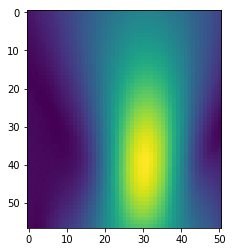

In [36]:
plt.imshow(ff250[:,:,25])

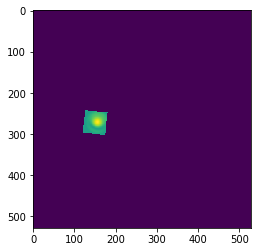

In [48]:
plt.imshow(ff_OverlayVox[:,:,40])

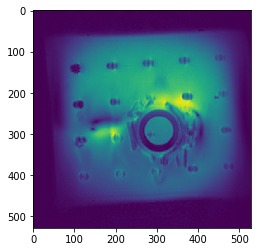

In [49]:
plt.imshow(T2wData[:,:,40])